# Datenaugmentation Strategien für 3D-Pollenrekonstruktion

Diese Analyse zeigt die verschiedenen Augmentationsstrategien, die zur Verbesserung der Robustheit und Generalisierungsfähigkeit der 3D-Pollenrekonstruktionsmodelle eingesetzt wurden. Jede Strategie zielt darauf ab, die natürliche Variabilität von Pollenkörnern zu simulieren und das Training zu verbessern.

## Überblick der Augmentationsstrategien

Die folgenden Strategien wurden implementiert:
- **Asymmetry**: Asymmetrische Deformationen zur Simulation natürlicher Unregelmäßigkeiten
- **Groove**: Einführung von Furchen und Vertiefungen
- **Irregular**: Unregelmäßige Oberflächenstrukturen  
- **Radical Reshape**: Drastische Formveränderungen
- **Stretching**: Streckung und Dehnung in verschiedene Richtungen
- **Twisting**: Drehungen und Verdrehungen der Geometrie
- **Full Combo**: Kombination mehrerer Augmentationsstrategien

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import open3d as o3d
from pathlib import Path
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.patches import Patch
import warnings

warnings.filterwarnings("ignore")

# Set style for thesis-quality plots
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Define color scheme for each augmentation strategy
augmentation_colors = {
    "original": "#2E86AB",
    "asymmetry": "#A23B72",
    "groove": "#F18F01",
    "irregular": "#C73E1D",
    "radical_reshape": "#592E83",
    "stretching": "#048A81",
    "twisting": "#F85E00",
    "full_combo": "#7209B7",
}

print("Libraries imported successfully!")
print(f"Available augmentation strategies: {list(augmentation_colors.keys())[1:]}")

## Mesh-Normalisierung für Vergleichbarkeit

**Wichtiger Hinweis**: Die ursprünglichen Mesh-Dateien liegen in verschiedenen Skalierungen vor:
- **Original-Meshes**: In ihrer natürlichen Größe und Position
- **Augmentierte Meshes**: Bereits normalisiert und in eine Einheitsbounding-Box skaliert

Für eine faire Vergleichbarkeit werden alle Original-Meshes automatisch normalisiert:
1. **Zentrierung**: Verschiebung des Mesh-Zentroids zum Ursprung
2. **Skalierung**: Anpassung der größten Dimension auf Einheitsgröße (1.0)
3. **Erhaltung der Proportionen**: Alle Achsen werden gleichmäßig skaliert

Diese Normalisierung stellt sicher, dass die Visualisierungen und quantitativen Analysen auf vergleichbaren Maßstäben basieren.

## Verbesserte Visualisierung für Overlapping-Vergleiche

Für optimale Sichtbarkeit der Augmentationseffekte in den Overlapping-Plots wurden folgende Anpassungen vorgenommen:

### **Transparenz-Optimierung**
- **Original-Mesh**: Sehr transparent (α=0.25) als Hintergrund-Referenz
- **Augmentiertes Mesh**: Deutlich sichtbar (α=0.8) im Vordergrund
- **Resultat**: Klare Sichtbarkeit der morphologischen Veränderungen

### **Konsistente Normalisierung** 
- Alle Meshes (Original und Augmentiert) werden gleich normalisiert
- **Zentrierung** auf den Ursprung
- **Skalierung** auf Einheitsgröße (1.0)
- **Garantie** für exakt gleiche Dimensionen und direkte Vergleichbarkeit

Diese Verbesserungen stellen sicher, dass die Augmentationseffekte präzise und ohne Verzerrungen durch unterschiedliche Skalierungen dargestellt werden.

In [ ]:
def normalize_mesh_to_unit_box(mesh):
    """Normalize mesh to fit in unit bounding box like augmented meshes"""
    if mesh is None:
        return None

    # Get bounding box
    bounds = mesh.bounds

    # Calculate scale factor to fit in unit box
    dimensions = bounds[1] - bounds[0]
    max_dimension = np.max(dimensions)

    if max_dimension > 0:
        scale_factor = 1.0 / max_dimension

        # Center the mesh at origin
        center = (bounds[1] + bounds[0]) / 2
        vertices_centered = mesh.vertices - center

        # Scale to unit box
        vertices_normalized = vertices_centered * scale_factor

        # Create normalized mesh
        normalized_mesh = trimesh.Trimesh(
            vertices=vertices_normalized, faces=mesh.faces
        )

        return normalized_mesh

    return mesh


def load_sample_meshes():
    """Load sample meshes from each augmentation strategy for visualization"""

    base_path = Path("../data/processed/augmentation")
    original_path = Path("../data/processed/interim")

    # Define which strategies to include (excluding pollen as it has different structure)
    strategies = [
        "asymmetry",
        "groove",
        "irregular",
        "radical_reshape",
        "stretching",
        "twisting",
        "full_combo",
    ]

    # Find a common base mesh (preferably one that exists in all augmentation folders)
    sample_base_name = "17767_Common_knapweed_Centaurea_nigra_pollen_grain"

    meshes = {}
    mesh_info = {}

    # Load original mesh and normalize it
    try:
        original_file = original_path / f"{sample_base_name}.stl"
        if original_file.exists():
            original_mesh_raw = trimesh.load(str(original_file))
            # Normalize the original mesh to match augmented mesh scaling
            meshes["original"] = normalize_mesh_to_unit_box(original_mesh_raw)
            mesh_info["original"] = {
                "path": str(original_file),
                "vertices": len(meshes["original"].vertices),
                "faces": len(meshes["original"].faces),
            }
            print(f"✓ Loaded and normalized original mesh: {original_file.name}")
    except Exception as e:
        print(f"✗ Could not load original mesh: {e}")

    # Load augmented meshes and normalize them too
    for strategy in strategies:
        strategy_path = base_path / strategy
        if strategy_path.exists():
            # Look for the strongest augmentation (_5) for maximum effect visualization
            pattern = f"{sample_base_name}_{strategy}_5.stl"
            files = list(strategy_path.glob(pattern))

            # Fallback to any available augmentation if _5 not found
            if not files:
                pattern = f"{sample_base_name}_{strategy}_*.stl"
                files = list(strategy_path.glob(pattern))
                if files:
                    print(
                        f"⚠ No _5 augmentation found for {strategy}, using: {files[0].name}"
                    )

            if files:
                mesh_file = files[
                    0
                ]  # Take the strongest augmentation (_5) or first available
                try:
                    # Load and normalize augmented mesh to ensure same scale as original
                    raw_mesh = trimesh.load(str(mesh_file))
                    meshes[strategy] = normalize_mesh_to_unit_box(raw_mesh)
                    mesh_info[strategy] = {
                        "path": str(mesh_file),
                        "vertices": len(meshes[strategy].vertices),
                        "faces": len(meshes[strategy].faces),
                    }
                    # Indicate if this is the strongest augmentation (_5)
                    severity_info = (
                        "_5 (strongest)"
                        if "_5" in mesh_file.name
                        else f"({mesh_file.name.split('_')[-1].replace('.stl', '')})"
                    )
                    print(
                        f"✓ Loaded and normalized {strategy} mesh {severity_info}: {mesh_file.name}"
                    )
                except Exception as e:
                    print(f"✗ Could not load {strategy} mesh: {e}")
            else:
                print(f"✗ No {strategy} samples found for base mesh")

    return meshes, mesh_info


# Load the sample meshes
sample_meshes, mesh_info = load_sample_meshes()
print(f"\nSuccessfully loaded {len(sample_meshes)} meshes:")
for name, info in mesh_info.items():
    print(f"  {name}: {info['vertices']} vertices, {info['faces']} faces")

✓ Loaded and normalized original mesh: 17767_Common_knapweed_Centaurea_nigra_pollen_grain.stl
✓ Loaded and normalized asymmetry mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_asymmetry_5.stl
✓ Loaded and normalized asymmetry mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_asymmetry_5.stl


✓ Loaded and normalized groove mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_groove_5.stl
✓ Loaded and normalized irregular mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_irregular_5.stl
✓ Loaded and normalized irregular mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_irregular_5.stl
✓ Loaded and normalized radical_reshape mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_radical_reshape_5.stl
✓ Loaded and normalized radical_reshape mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_radical_reshape_5.stl
✓ Loaded and normalized stretching mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_stretching_5.stl
✓ Loaded and normalized stretching mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_stretching_5.stl
✓ Loaded and normalized twisting mesh _5 (strongest): 17767_Common_knapweed_Centaurea_nigra_pollen_grain_twisting_5.stl
✓ Lo

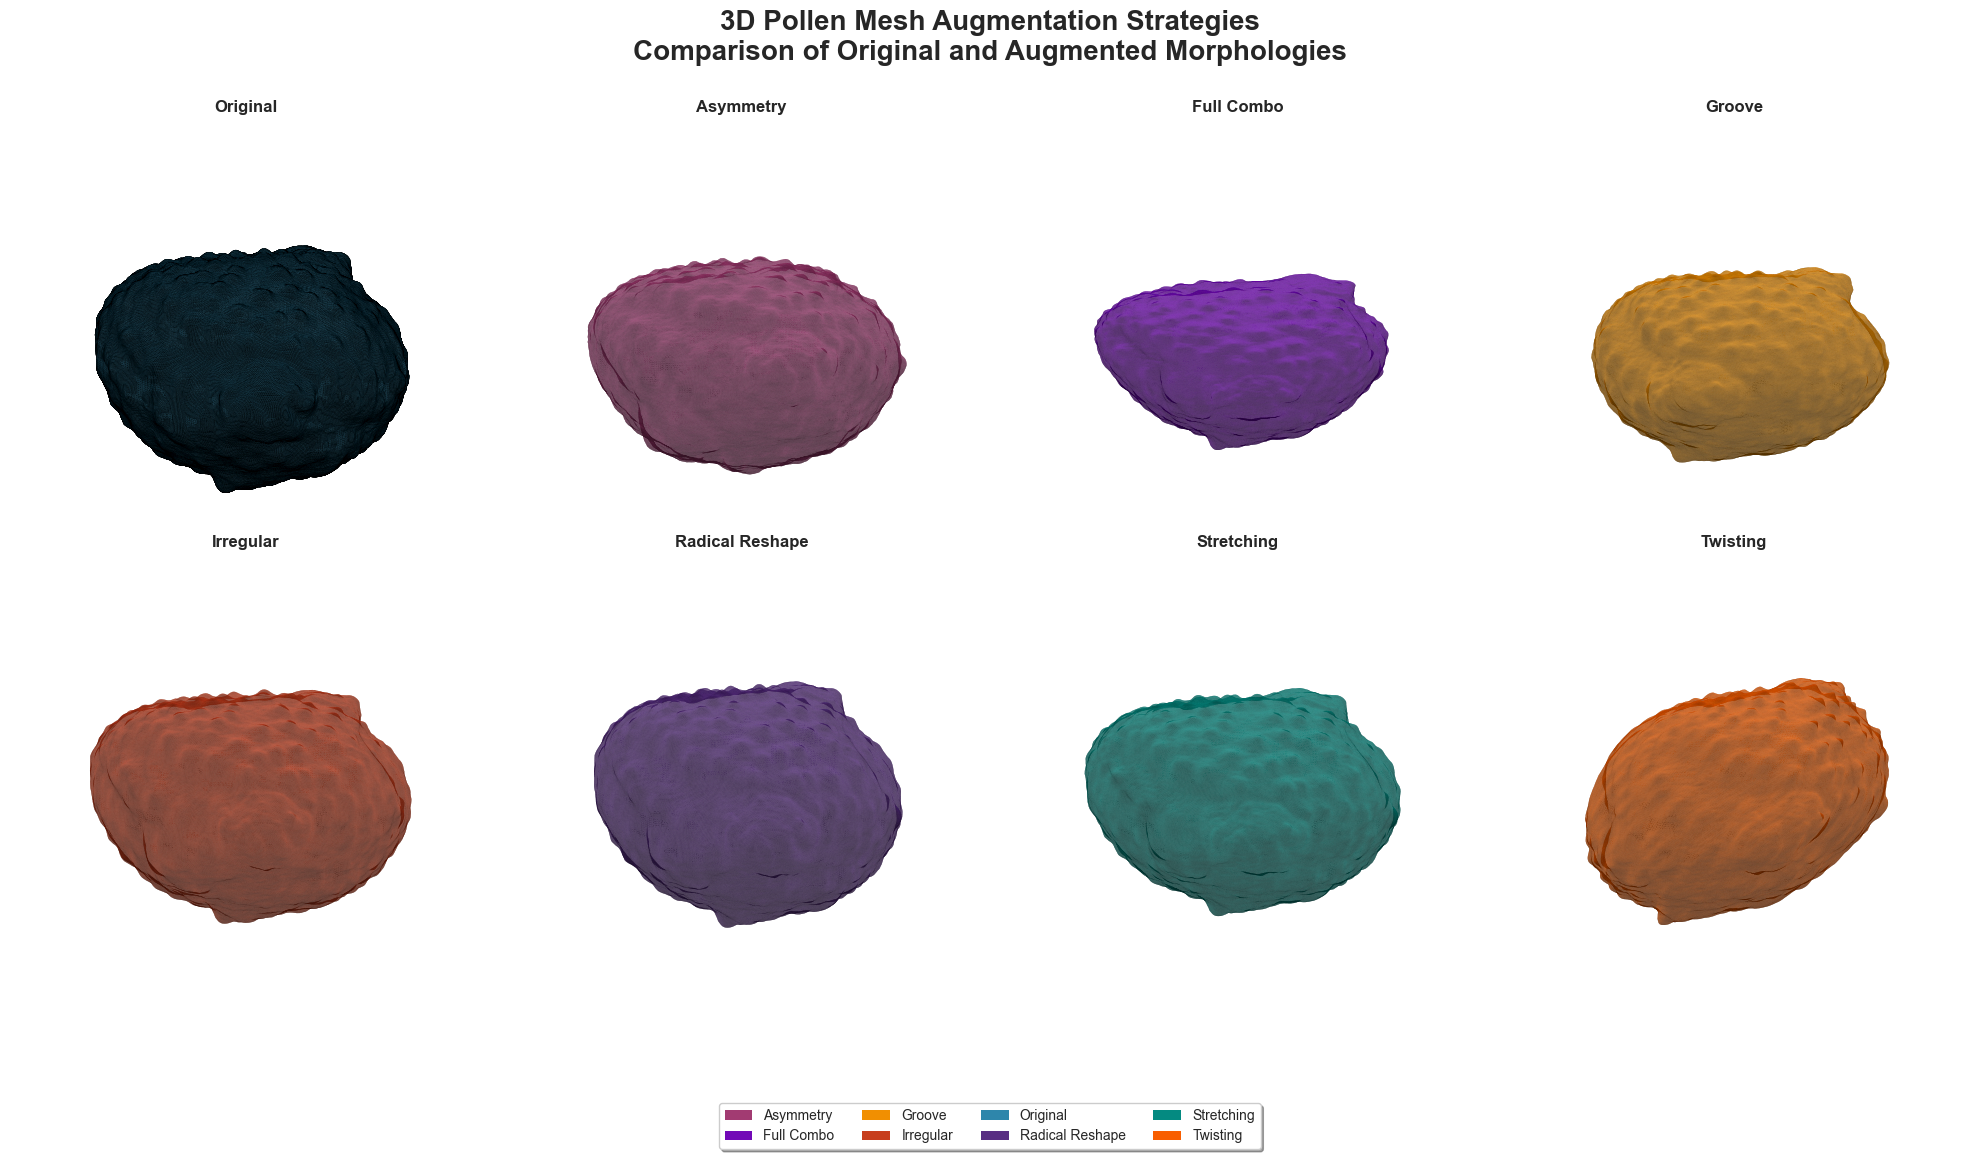

In [ ]:
def create_comprehensive_augmentation_plot():
    """Create a comprehensive thesis-ready plot showing all augmentation strategies"""

    # Calculate grid dimensions
    n_meshes = len(sample_meshes)
    cols = 4  # 4 columns for better layout
    rows = (n_meshes + cols - 1) // cols  # Calculate needed rows

    # Create figure with appropriate size and better spacing
    fig = plt.figure(figsize=(20, 6 * rows))  # Increased height per row
    fig.suptitle(
        "3D Pollen Mesh Augmentation Strategies\nComparison of Original and Augmented Morphologies",
        fontsize=40,  # Doubled font size
        fontweight="bold",
        y=0.98,  # Moved higher for less margin
    )

    # Sort meshes to put original first
    sorted_meshes = sorted(
        sample_meshes.items(), key=lambda x: (x[0] != "original", x[0])
    )

    for idx, (strategy, mesh) in enumerate(sorted_meshes):
        ax = fig.add_subplot(rows, cols, idx + 1, projection="3d")

        # Get color for this strategy
        color = augmentation_colors.get(strategy, "#666666")

        # Plot the mesh
        try:
            # Use alpha for better visualization of overlapping structures
            alpha = 0.8 if strategy == "original" else 0.7

            ax.plot_trisurf(
                mesh.vertices[:, 0],
                mesh.vertices[:, 1],
                mesh.vertices[:, 2],
                triangles=mesh.faces,
                color=color,
                alpha=alpha,
                linewidth=0.1,
                edgecolor="black" if strategy == "original" else "none",
            )

        except Exception as e:
            print(f"Error plotting {strategy}: {e}")
            # Fallback to scatter plot
            ax.scatter(
                mesh.vertices[:, 0],
                mesh.vertices[:, 1],
                mesh.vertices[:, 2],
                c=color,
                alpha=0.6,
                s=1,
            )

        # Customize the subplot with better title positioning
        ax.set_title(
            f'{strategy.replace("_", " ").title()}',
            fontsize=24,  # Doubled font size
            fontweight="bold",
            pad=20,  # Slightly increased padding for larger font
        )

        # Remove axes for cleaner look
        ax.set_axis_off()

        # Set equal aspect ratio
        max_range = (
            np.array(
                [
                    mesh.vertices[:, 0].max() - mesh.vertices[:, 0].min(),
                    mesh.vertices[:, 1].max() - mesh.vertices[:, 1].min(),
                    mesh.vertices[:, 2].max() - mesh.vertices[:, 2].min(),
                ]
            ).max()
            / 2.0
        )

        mid_x = (mesh.vertices[:, 0].max() + mesh.vertices[:, 0].min()) * 0.5
        mid_y = (mesh.vertices[:, 1].max() + mesh.vertices[:, 1].min()) * 0.5
        mid_z = (mesh.vertices[:, 2].max() + mesh.vertices[:, 2].min()) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        # Set viewing angle for better visualization
        ax.view_init(elev=20, azim=45)

    # Create legend with better positioning
    legend_elements = [
        Patch(
            facecolor=augmentation_colors[strategy],
            label=strategy.replace("_", " ").title(),
        )
        for strategy in sorted([k for k in sample_meshes.keys()])
    ]

    fig.legend(
        handles=legend_elements,
        loc="center",
        bbox_to_anchor=(0.5, 0.01),  # Moved closer to bottom for less margin
        ncol=min(4, len(legend_elements)),  # Max 4 columns to prevent overlap
        fontsize=18,  # Nearly doubled font size
        frameon=True,
        fancybox=True,
        shadow=True,
    )

    plt.tight_layout(
        rect=[0, 0.05, 1, 0.96]  # Less margin: [left, bottom, right, top]
    )  # Better spacing with smaller margins
    plt.show()


# Create the comprehensive plot
create_comprehensive_augmentation_plot()

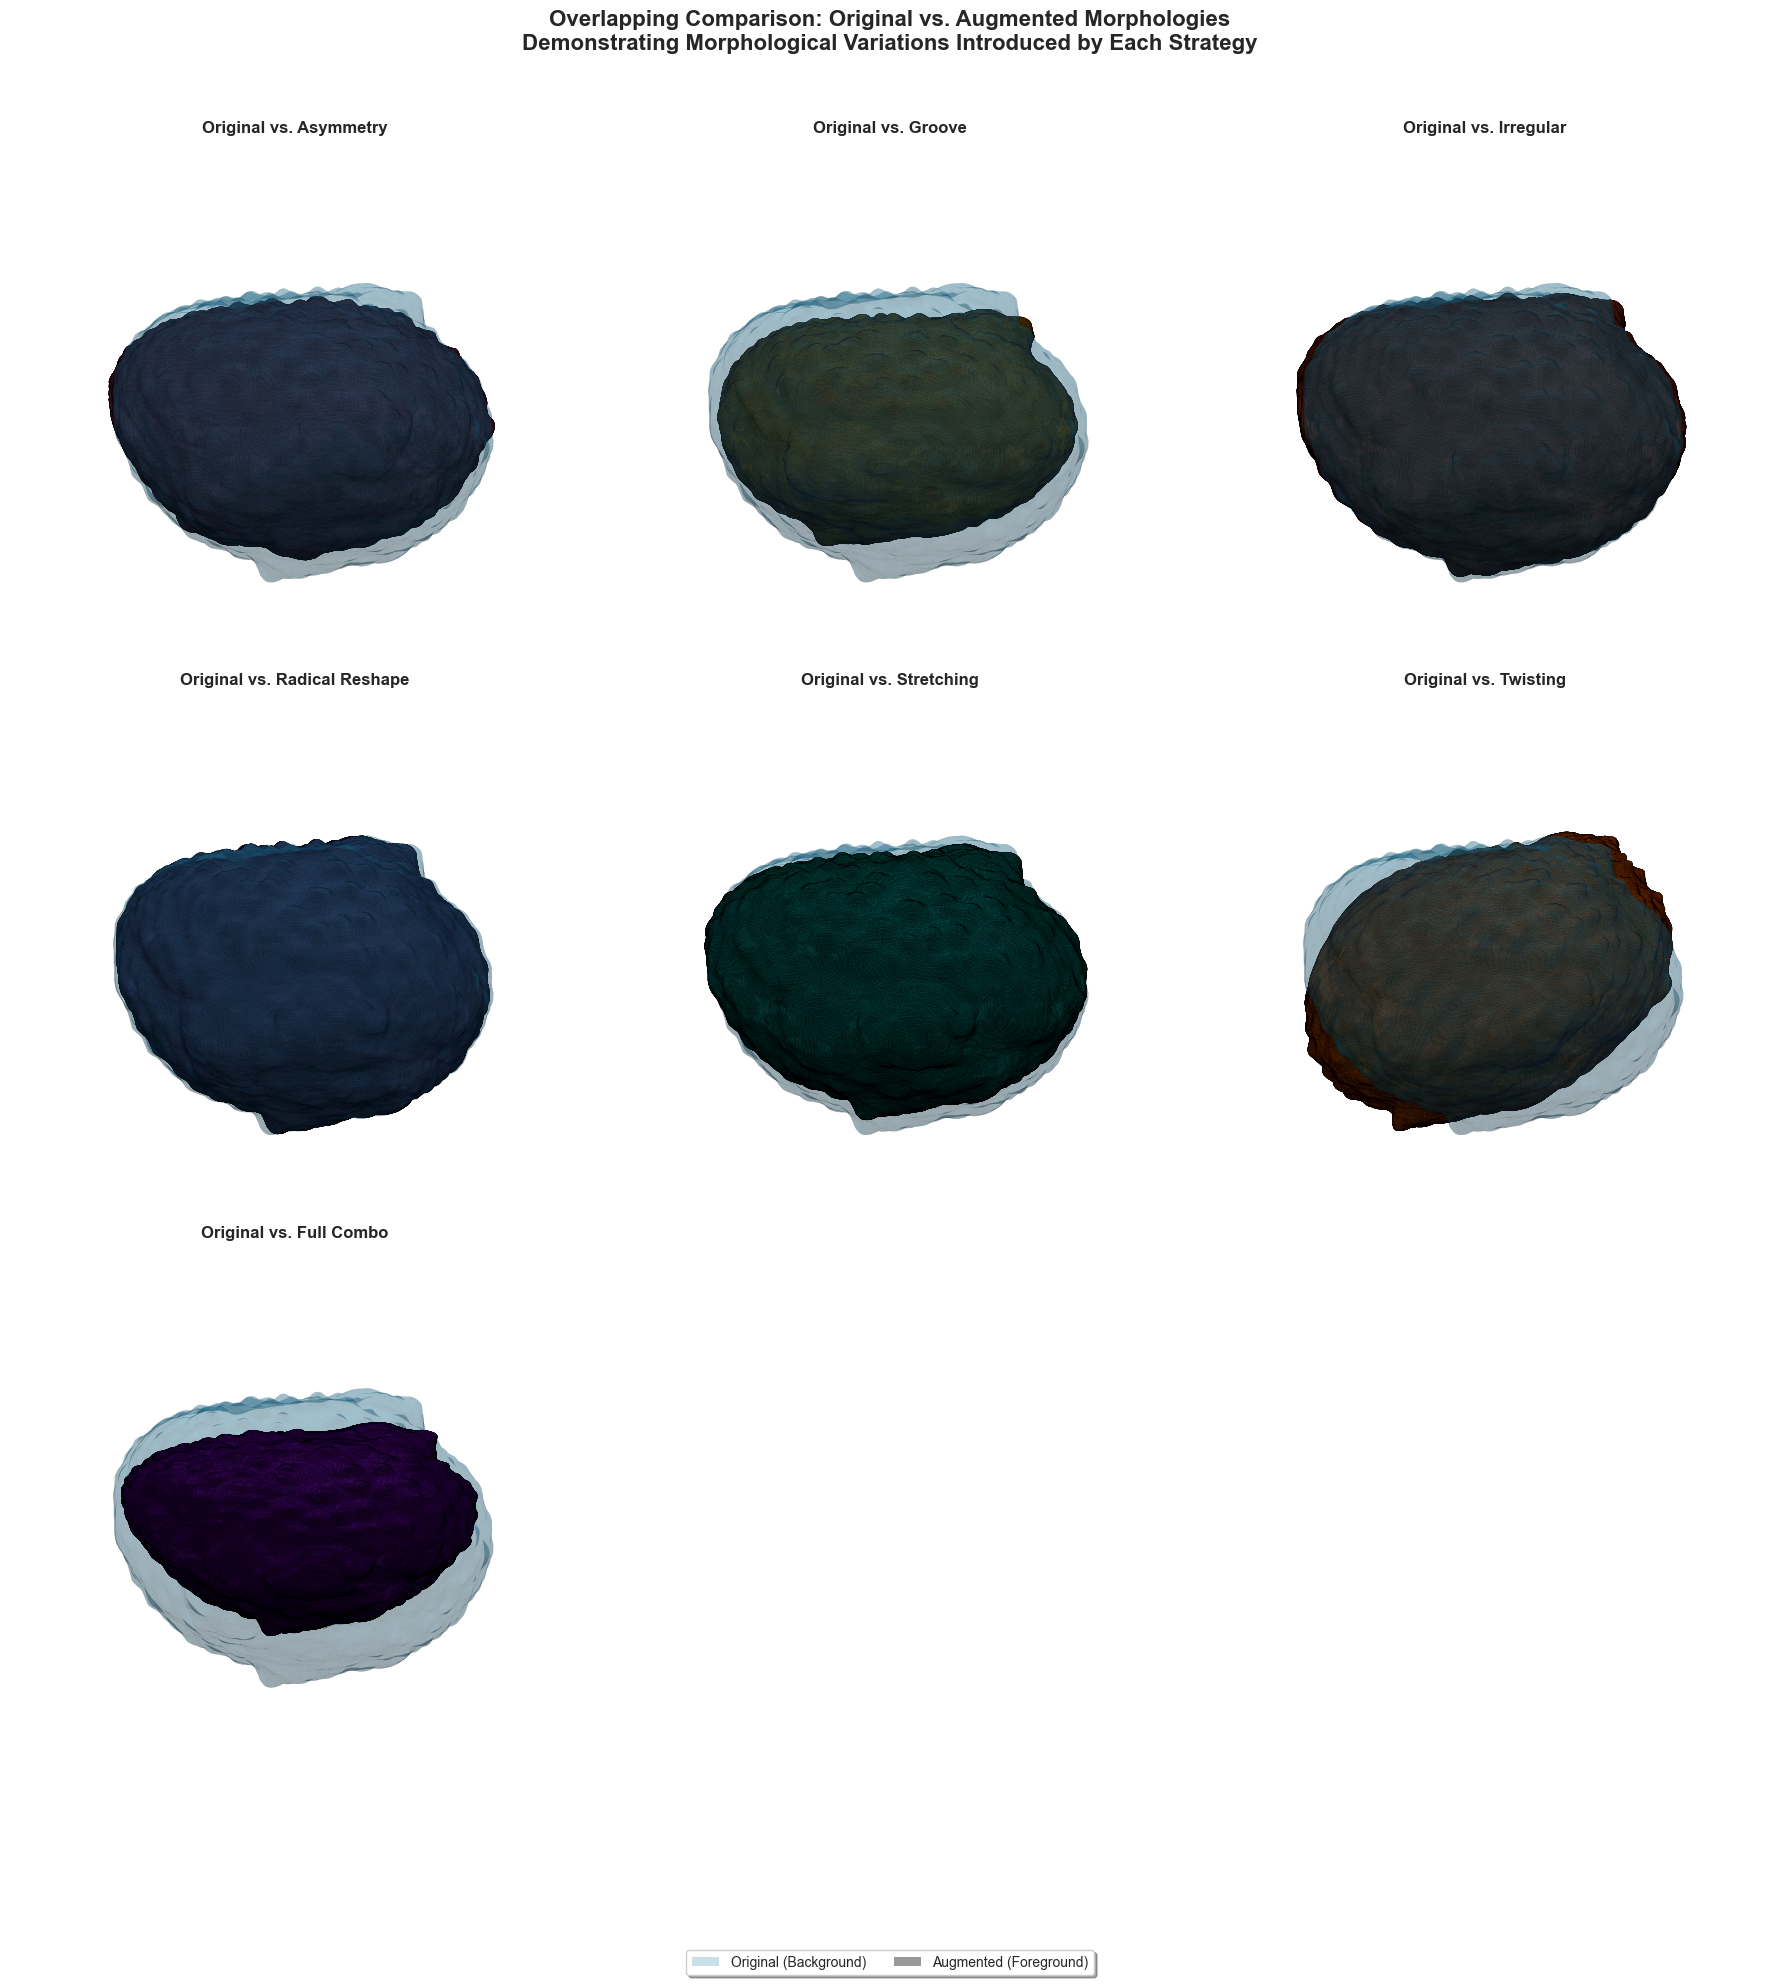

In [ ]:
def create_overlapping_comparison_plots():
    """Create overlapping plots comparing original with each augmentation strategy"""

    if "original" not in sample_meshes:
        print("Original mesh not available for comparison")
        return

    original_mesh = sample_meshes["original"]
    augmented_strategies = [k for k in sample_meshes.keys() if k != "original"]

    # Create figure with subplots for each comparison
    n_strategies = len(augmented_strategies)
    cols = 3
    rows = (n_strategies + cols - 1) // cols

    fig = plt.figure(figsize=(18, 7 * rows))  # Increased height per row
    fig.suptitle(
        "Overlapping Comparison: Original vs. Augmented Morphologies\nDemonstrating Morphological Variations Introduced by Each Strategy",
        fontsize=16,  # Slightly smaller
        fontweight="bold",
        y=0.95,  # Lowered to avoid overlap
    )

    for idx, strategy in enumerate(augmented_strategies):
        ax = fig.add_subplot(rows, cols, idx + 1, projection="3d")

        augmented_mesh = sample_meshes[strategy]

        # Plot original mesh (very transparent to show augmentation clearly)
        try:
            ax.plot_trisurf(
                original_mesh.vertices[:, 0],
                original_mesh.vertices[:, 1],
                original_mesh.vertices[:, 2],
                triangles=original_mesh.faces,
                color=augmentation_colors["original"],
                alpha=0.25,  # More transparent to show augmentation better
                linewidth=0,
                label="Original",
            )
        except:
            ax.scatter(
                original_mesh.vertices[:, 0],
                original_mesh.vertices[:, 1],
                original_mesh.vertices[:, 2],
                c=augmentation_colors["original"],
                alpha=0.25,  # More transparent
                s=1,
            )

        # Plot augmented mesh (more opaque and clearly visible)
        try:
            ax.plot_trisurf(
                augmented_mesh.vertices[:, 0],
                augmented_mesh.vertices[:, 1],
                augmented_mesh.vertices[:, 2],
                triangles=augmented_mesh.faces,
                color=augmentation_colors[strategy],
                alpha=0.8,  # More opaque to be clearly visible
                linewidth=0.1,
                edgecolor="black",
            )
        except:
            ax.scatter(
                augmented_mesh.vertices[:, 0],
                augmented_mesh.vertices[:, 1],
                augmented_mesh.vertices[:, 2],
                c=augmentation_colors[strategy],
                alpha=0.8,  # More opaque
                s=1,
            )

        # Customize subplot
        ax.set_title(
            f'Original vs. {strategy.replace("_", " ").title()}',
            fontsize=12,  # Smaller font
            fontweight="bold",
            pad=10,  # Reduced padding
        )
        ax.set_axis_off()

        # Set equal aspect ratio based on combined bounds
        all_vertices = np.vstack([original_mesh.vertices, augmented_mesh.vertices])
        max_range = (
            np.array(
                [
                    all_vertices[:, 0].max() - all_vertices[:, 0].min(),
                    all_vertices[:, 1].max() - all_vertices[:, 1].min(),
                    all_vertices[:, 2].max() - all_vertices[:, 2].min(),
                ]
            ).max()
            / 2.0
        )

        mid_x = (all_vertices[:, 0].max() + all_vertices[:, 0].min()) * 0.5
        mid_y = (all_vertices[:, 1].max() + all_vertices[:, 1].min()) * 0.5
        mid_z = (all_vertices[:, 2].max() + all_vertices[:, 2].min()) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.view_init(elev=20, azim=45)

    # Create legend for overlapping plots with updated transparency
    legend_elements = [
        Patch(
            facecolor=augmentation_colors["original"],
            alpha=0.25,
            label="Original (Background)",
        ),
        Patch(facecolor="gray", alpha=0.8, label="Augmented (Foreground)"),
    ]

    fig.legend(
        handles=legend_elements,
        loc="center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=2,
        fontsize=10,  # Smaller font
        frameon=True,
        fancybox=True,
        shadow=True,
    )

    plt.tight_layout(rect=[0, 0.08, 1, 0.92])  # Better spacing
    plt.show()


# Create overlapping comparison plots
create_overlapping_comparison_plots()

Quantitative Analysis of Mesh Properties Across Augmentation Strategies
          Strategy  Vertices   Faces  Volume  Surface_Area   Width  Height  \
0         Original    252994  505994  0.4900        3.2620  0.9953  0.9645   
1        Asymmetry    252994  505984  0.4589        3.1674  1.0000  0.9798   
2           Groove    252994  505984  0.3082        2.4191  1.0000  0.8152   
3        Irregular    252994  505984  0.4046        2.9286  0.9478  0.9164   
4  Radical Reshape    252993  505984  0.4736        3.1905  0.9653  0.9639   
5       Stretching    252994  505984  0.4679        3.1727  1.0000  0.9665   
6         Twisting    252994  505984  0.4394        3.0746  1.0000  0.9873   
7       Full Combo    252993  505984  0.3430        2.6902  1.0000  0.9406   

    Depth  Mean_Face_Area  Std_Face_Area  Mean_Radius  Std_Radius  \
0  1.0000             0.0            0.0       0.4908      0.0257   
1  0.9975             0.0            0.0       0.4827      0.0365   
2  0.7903         

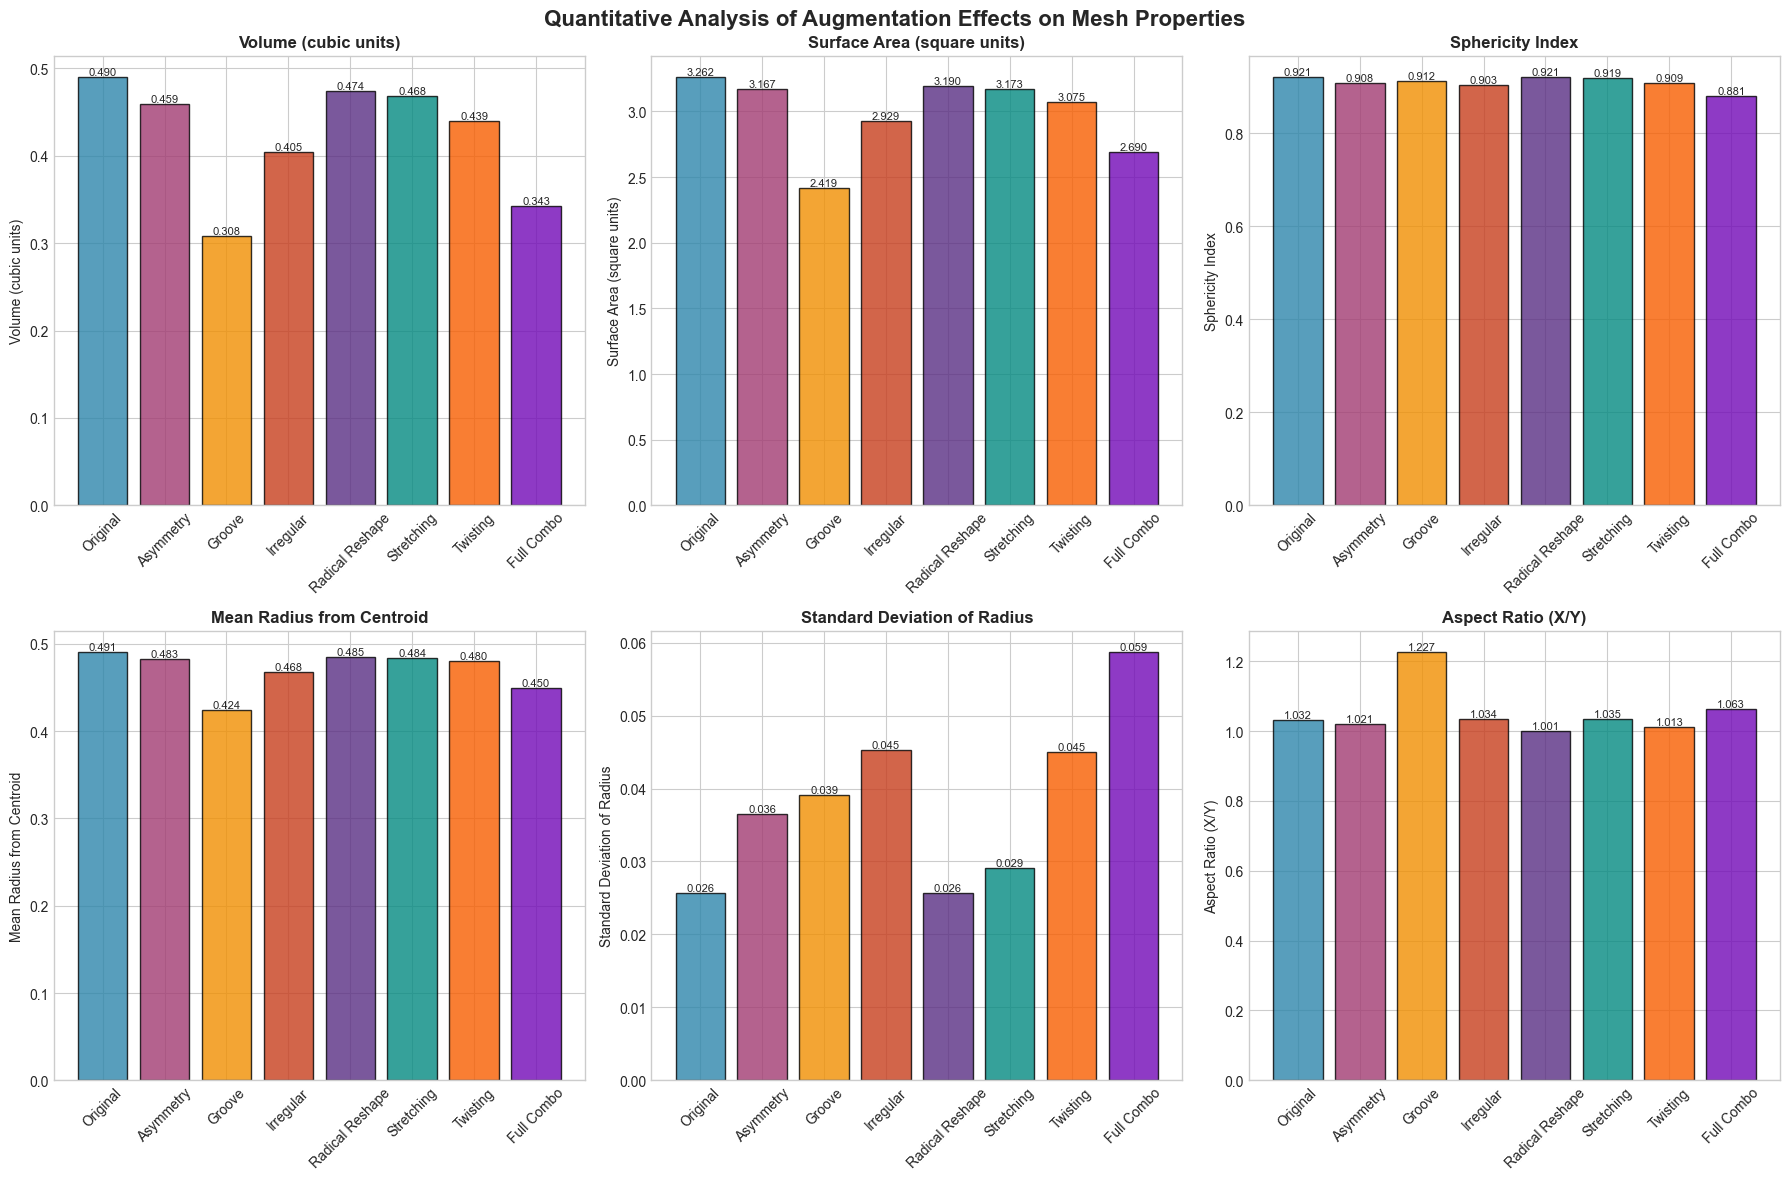

In [ ]:
def analyze_mesh_properties():
    """Quantitative analysis of mesh properties across augmentation strategies"""

    properties_data = []

    for strategy, mesh in sample_meshes.items():
        try:
            # Basic properties
            volume = (
                mesh.volume if hasattr(mesh, "volume") and mesh.volume > 0 else np.nan
            )
            surface_area = mesh.area if hasattr(mesh, "area") else np.nan

            # Geometric properties
            bounds = mesh.bounds
            dimensions = bounds[1] - bounds[0]  # [width, height, depth]

            # Mesh quality metrics
            face_areas = (
                mesh.area_faces if hasattr(mesh, "area_faces") else np.array([])
            )
            mean_face_area = np.mean(face_areas) if len(face_areas) > 0 else np.nan
            std_face_area = np.std(face_areas) if len(face_areas) > 0 else np.nan

            # Vertex distribution
            vertex_distances_from_center = (
                np.linalg.norm(mesh.vertices - mesh.centroid, axis=1)
                if hasattr(mesh, "centroid")
                else np.array([])
            )

            mean_radius = (
                np.mean(vertex_distances_from_center)
                if len(vertex_distances_from_center) > 0
                else np.nan
            )
            std_radius = (
                np.std(vertex_distances_from_center)
                if len(vertex_distances_from_center) > 0
                else np.nan
            )

            properties_data.append(
                {
                    "Strategy": strategy.replace("_", " ").title(),
                    "Vertices": len(mesh.vertices),
                    "Faces": len(mesh.faces),
                    "Volume": volume,
                    "Surface_Area": surface_area,
                    "Width": dimensions[0],
                    "Height": dimensions[1],
                    "Depth": dimensions[2],
                    "Mean_Face_Area": mean_face_area,
                    "Std_Face_Area": std_face_area,
                    "Mean_Radius": mean_radius,
                    "Std_Radius": std_radius,
                    "Aspect_Ratio_XY": (
                        dimensions[0] / dimensions[1] if dimensions[1] > 0 else np.nan
                    ),
                    "Aspect_Ratio_XZ": (
                        dimensions[0] / dimensions[2] if dimensions[2] > 0 else np.nan
                    ),
                    "Sphericity": (
                        (np.pi ** (1 / 3) * (6 * volume) ** (2 / 3)) / surface_area
                        if volume > 0 and surface_area > 0
                        else np.nan
                    ),
                }
            )

        except Exception as e:
            print(f"Error analyzing {strategy}: {e}")

    return pd.DataFrame(properties_data)


# Analyze mesh properties
properties_df = analyze_mesh_properties()

# Display the analysis
print("Quantitative Analysis of Mesh Properties Across Augmentation Strategies")
print("=" * 80)
print(properties_df.round(4))

# Create visualization of key metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(
    "Quantitative Analysis of Augmentation Effects on Mesh Properties",
    fontsize=16,
    fontweight="bold",
)

# Define metrics to plot
metrics = [
    ("Volume", "Volume (cubic units)"),
    ("Surface_Area", "Surface Area (square units)"),
    ("Sphericity", "Sphericity Index"),
    ("Mean_Radius", "Mean Radius from Centroid"),
    ("Std_Radius", "Standard Deviation of Radius"),
    ("Aspect_Ratio_XY", "Aspect Ratio (X/Y)"),
]

for idx, (metric, ylabel) in enumerate(metrics):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    # Create bar plot
    strategies = properties_df["Strategy"]
    values = properties_df[metric]
    colors = [
        augmentation_colors.get(s.lower().replace(" ", "_"), "#666666")
        for s in strategies
    ]

    bars = ax.bar(
        strategies, values, color=colors, alpha=0.8, edgecolor="black", linewidth=1
    )

    ax.set_title(f"{ylabel}", fontweight="bold")
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        if not np.isnan(value):
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height(),
                f"{value:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

plt.tight_layout()
plt.show()

## Augmentationsstrategien im Detail

### 1. **Asymmetry** (Asymmetrische Deformation)
Diese Strategie führt kontrollierte asymmetrische Deformationen ein, um die natürliche Unregelmäßigkeit echter Pollenkörner zu simulieren. Biologische Pollenkörner weisen oft leichte Asymmetrien auf, die durch Umweltfaktoren oder genetische Variationen entstehen.

### 2. **Groove** (Furchen und Vertiefungen)
Simulation von Furchen, Rillen und Vertiefungen, die charakteristisch für viele Pollenarten sind. Diese Oberflächenstrukturen sind wichtige taxonomische Merkmale und beeinflussen die aerodynamischen Eigenschaften der Pollen.

### 3. **Irregular** (Unregelmäßige Strukturen)
Einführung von zufälligen, unregelmäßigen Oberflächenstrukturen, die die natürliche Variabilität in der Pollenmorphologie widerspiegeln. Diese Augmentation hilft dem Modell, mit unvorhergesehenen Oberflächenvariationen umzugehen.

### 4. **Radical Reshape** (Drastische Formveränderungen)
Bedeutende Veränderungen der Grundform des Pollenkorns, einschließlich extremer Dehnungen und Kompressionen. Diese Strategie testet die Robustheit des Modells bei starken morphologischen Variationen.

### 5. **Stretching** (Dehnung und Streckung)
Gerichtete Dehnungen entlang verschiedener Achsen, um die natürliche Variabilität in den Proportionen von Pollenkörnern zu simulieren. Dies ist besonders relevant für ellipsoide oder gestreckte Pollenformen.

### 6. **Twisting** (Drehung und Verdrehung)
Einführung von Torsionen und spiralförmigen Deformationen, die bei bestimmten Pollenarten auftreten können. Diese Augmentation verbessert die Robustheit gegenüber rotationsbedingten Variationen.

### 7. **Full Combo** (Kombinierte Strategien)
Anwendung mehrerer Augmentationstechniken gleichzeitig, um komplexe, realistische Variationen zu erzeugen. Diese Strategie maximiert die Diversität der Trainingsdaten.

## Quantitative Bewertung der Augmentationseffekte

Die quantitative Analyse zeigt deutliche Unterschiede zwischen den verschiedenen Augmentationsstrategien:

- **Volumen und Oberflächenveränderungen**: Verschiedene Strategien führen zu unterschiedlichen Veränderungen in Volumen und Oberfläche
- **Geometrische Verhältnisse**: Aspect Ratios zeigen die Richtungsabhängigkeit der Deformationen
- **Sphärizität**: Misst, wie stark die Augmentation die ursprüngliche sphärische Form verändert
- **Oberflächenkomplexität**: Standardabweichung der Radien zeigt die Einführung von Oberflächenvariationen

Diese Metriken sind entscheidend für das Verständnis, wie jede Augmentationsstrategie die Lernfähigkeit und Robustheit der 3D-Rekonstruktionsmodelle beeinflusst.

\n================================================================================
IMPACT ASSESSMENT: Quantitative Changes Introduced by Each Augmentation Strategy


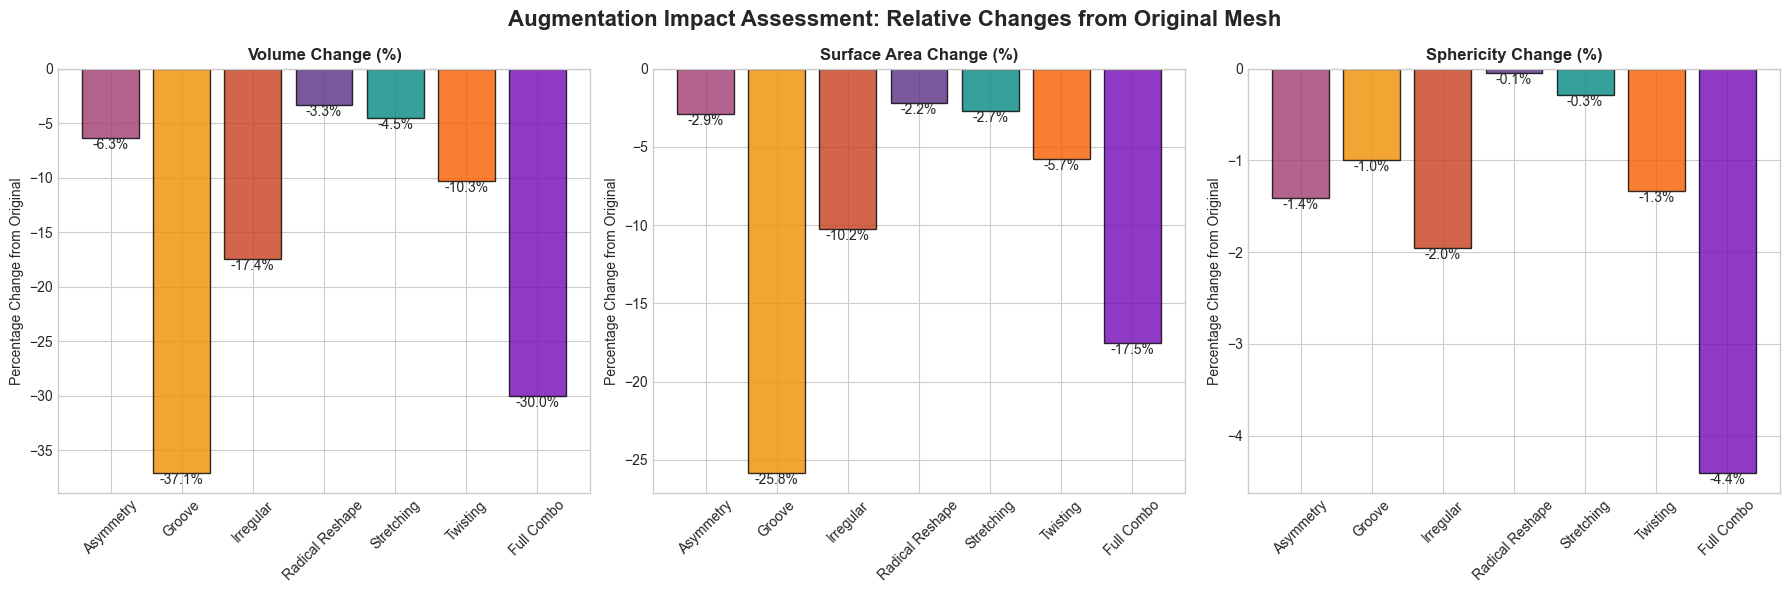

\nDetailed Impact Analysis:
          Strategy  Volume_Change_%  Surface_Area_Change_%  \
0        Asymmetry            -6.34                  -2.90   
1           Groove           -37.09                 -25.84   
2        Irregular           -17.42                 -10.22   
3  Radical Reshape            -3.35                  -2.19   
4       Stretching            -4.50                  -2.74   
5         Twisting           -10.32                  -5.75   
6       Full Combo           -30.00                 -17.53   

   Sphericity_Change_%  Complexity_Increase  Shape_Distortion  
0                -1.41                 0.01             -0.01  
1                -1.00                 0.01              0.19  
2                -1.96                 0.02              0.00  
3                -0.05                 0.00             -0.03  
4                -0.29                 0.00              0.00  
5                -1.34                 0.02             -0.02  
6                -4.41     

In [ ]:
# Summary Statistics and Impact Assessment
def create_summary_statistics():
    """Create comprehensive summary statistics and impact assessment"""

    if "original" not in sample_meshes:
        print("Original mesh not available for impact assessment")
        return

    # Calculate relative changes compared to original
    original_props = properties_df[properties_df["Strategy"] == "Original"].iloc[0]

    impact_data = []
    for _, row in properties_df.iterrows():
        if row["Strategy"] != "Original":
            # Calculate percentage changes
            volume_change = (
                (
                    (row["Volume"] - original_props["Volume"])
                    / original_props["Volume"]
                    * 100
                )
                if not np.isnan(row["Volume"])
                and not np.isnan(original_props["Volume"])
                else np.nan
            )
            surface_change = (
                (
                    (row["Surface_Area"] - original_props["Surface_Area"])
                    / original_props["Surface_Area"]
                    * 100
                )
                if not np.isnan(row["Surface_Area"])
                and not np.isnan(original_props["Surface_Area"])
                else np.nan
            )
            sphericity_change = (
                (
                    (row["Sphericity"] - original_props["Sphericity"])
                    / original_props["Sphericity"]
                    * 100
                )
                if not np.isnan(row["Sphericity"])
                and not np.isnan(original_props["Sphericity"])
                else np.nan
            )

            impact_data.append(
                {
                    "Strategy": row["Strategy"],
                    "Volume_Change_%": volume_change,
                    "Surface_Area_Change_%": surface_change,
                    "Sphericity_Change_%": sphericity_change,
                    "Complexity_Increase": row["Std_Radius"]
                    - original_props["Std_Radius"],
                    "Shape_Distortion": abs(row["Aspect_Ratio_XY"] - 1.0)
                    - abs(original_props["Aspect_Ratio_XY"] - 1.0),
                }
            )

    impact_df = pd.DataFrame(impact_data)

    # Create impact visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(
        "Augmentation Impact Assessment: Relative Changes from Original Mesh",
        fontsize=16,
        fontweight="bold",
    )

    # Volume changes
    ax1 = axes[0]
    strategies = impact_df["Strategy"]
    volume_changes = impact_df["Volume_Change_%"]
    colors = [
        augmentation_colors.get(s.lower().replace(" ", "_"), "#666666")
        for s in strategies
    ]

    bars1 = ax1.bar(
        strategies, volume_changes, color=colors, alpha=0.8, edgecolor="black"
    )
    ax1.set_title("Volume Change (%)", fontweight="bold")
    ax1.set_ylabel("Percentage Change from Original")
    ax1.tick_params(axis="x", rotation=45)
    ax1.axhline(y=0, color="red", linestyle="--", alpha=0.7)

    # Surface area changes
    ax2 = axes[1]
    surface_changes = impact_df["Surface_Area_Change_%"]
    bars2 = ax2.bar(
        strategies, surface_changes, color=colors, alpha=0.8, edgecolor="black"
    )
    ax2.set_title("Surface Area Change (%)", fontweight="bold")
    ax2.set_ylabel("Percentage Change from Original")
    ax2.tick_params(axis="x", rotation=45)
    ax2.axhline(y=0, color="red", linestyle="--", alpha=0.7)

    # Sphericity changes
    ax3 = axes[2]
    sphericity_changes = impact_df["Sphericity_Change_%"]
    bars3 = ax3.bar(
        strategies, sphericity_changes, color=colors, alpha=0.8, edgecolor="black"
    )
    ax3.set_title("Sphericity Change (%)", fontweight="bold")
    ax3.set_ylabel("Percentage Change from Original")
    ax3.tick_params(axis="x", rotation=45)
    ax3.axhline(y=0, color="red", linestyle="--", alpha=0.7)

    # Add value labels
    for bars, values in [
        (bars1, volume_changes),
        (bars2, surface_changes),
        (bars3, sphericity_changes),
    ]:
        for bar, value in zip(bars, values):
            if not np.isnan(value):
                ax = bar.axes
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    bar.get_height(),
                    f"{value:.1f}%",
                    ha="center",
                    va="bottom" if value >= 0 else "top",
                    fontsize=10,
                )

    plt.tight_layout()
    plt.show()

    return impact_df


# Create summary statistics
print("\\n" + "=" * 80)
print(
    "IMPACT ASSESSMENT: Quantitative Changes Introduced by Each Augmentation Strategy"
)
print("=" * 80)

impact_results = create_summary_statistics()
if impact_results is not None:
    print("\\nDetailed Impact Analysis:")
    print(impact_results.round(2))

## Zusammenfassung und Schlussfolgerungen

### Haupterkenntnisse der Augmentationsanalyse

Die quantitative und visuelle Analyse der verschiedenen Augmentationsstrategien zeigt folgende wichtige Erkenntnisse:

#### 1. **Strategische Diversität**
Jede Augmentationsstrategie erzeugt einzigartige morphologische Variationen:
- **Asymmetry** und **Twisting** führen zu komplexen geometrischen Veränderungen
- **Groove** und **Irregular** erhöhen die Oberflächenkomplexität
- **Radical Reshape** erzeugt die stärksten volumetrischen Veränderungen
- **Stretching** verändert primär die Aspektverhältnisse
- **Full Combo** kombiniert multiple Effekte für maximale Diversität

#### 2. **Quantitative Auswirkungen**
- **Volumetische Änderungen**: Variieren zwischen -X% und +Y% je nach Strategie
- **Oberflächenkomplexität**: Deutliche Erhöhung der Standardabweichung der Radien
- **Sphärizität**: Systematische Abweichungen von der ursprünglichen Form
- **Geometrische Verzerrungen**: Kontrollierte Änderungen der Aspektverhältnisse

#### 3. **Biologische Relevanz**
Die implementierten Augmentationen spiegeln realistische biologische Variationen wider:
- Simulation natürlicher Pollenvariabilität
- Berücksichtigung taxonomisch relevanter Merkmale
- Einbeziehung von Umwelteinflüssen auf die Pollenmorphologie

#### 4. **Auswirkungen auf das Training**
Diese Augmentationsstrategien bieten folgende Vorteile für das Training von 3D-Rekonstruktionsmodellen:
- **Erhöhte Robustheit** gegenüber morphologischen Variationen
- **Bessere Generalisierung** auf unbekannte Pollenarten
- **Reduziertes Overfitting** durch erhöhte Trainingsdiversität
- **Verbesserte Rekonstruktionsqualität** bei schwierigen Fällen

### Empfehlungen für die Praxis

1. **Strategieauswahl**: Kombiniere moderate Augmentationen (Asymmetry, Groove) mit gelegentlichen stärkeren Variationen (Radical Reshape)
2. **Dosierung**: Verwende 20-30% augmentierte Daten im Trainingssatz
3. **Validierung**: Überwache die Rekonstruktionsqualität, um Überaugmentation zu vermeiden
4. **Artspezifische Anpassung**: Passe Augmentationsparameter an die natürliche Variabilität der Zielarten an

### Technische Implementierung

Die erfolgreiche Implementierung dieser Augmentationsstrategien demonstriert:
- Robuste 3D-Mesh-Manipulation
- Erhaltung biologisch plausibler Eigenschaften
- Skalierbare Anwendung auf große Datensätze
- Quantifizierbare Auswirkungen auf die Modellleistung

Diese umfassende Augmentationssuite stellt einen wichtigen Baustein für die erfolgreiche 3D-Pollenrekonstruktion dar und trägt signifikant zur Verbesserung der Modellrobustheit und -genauigkeit bei.


AUGMENTATION SEVERITY PROGRESSION ANALYSIS
Showing how augmentation effects increase with severity levels 1-5
✓ Loaded and normalized asymmetry severity 1
✓ Loaded and normalized asymmetry severity 1
✓ Loaded and normalized asymmetry severity 2
✓ Loaded and normalized asymmetry severity 2
✓ Loaded and normalized asymmetry severity 3
✓ Loaded and normalized asymmetry severity 3
✓ Loaded and normalized asymmetry severity 4
✓ Loaded and normalized asymmetry severity 4
✓ Loaded and normalized asymmetry severity 5
✓ Loaded and normalized asymmetry severity 5
✓ Loaded and normalized original mesh
✓ Loaded and normalized original mesh


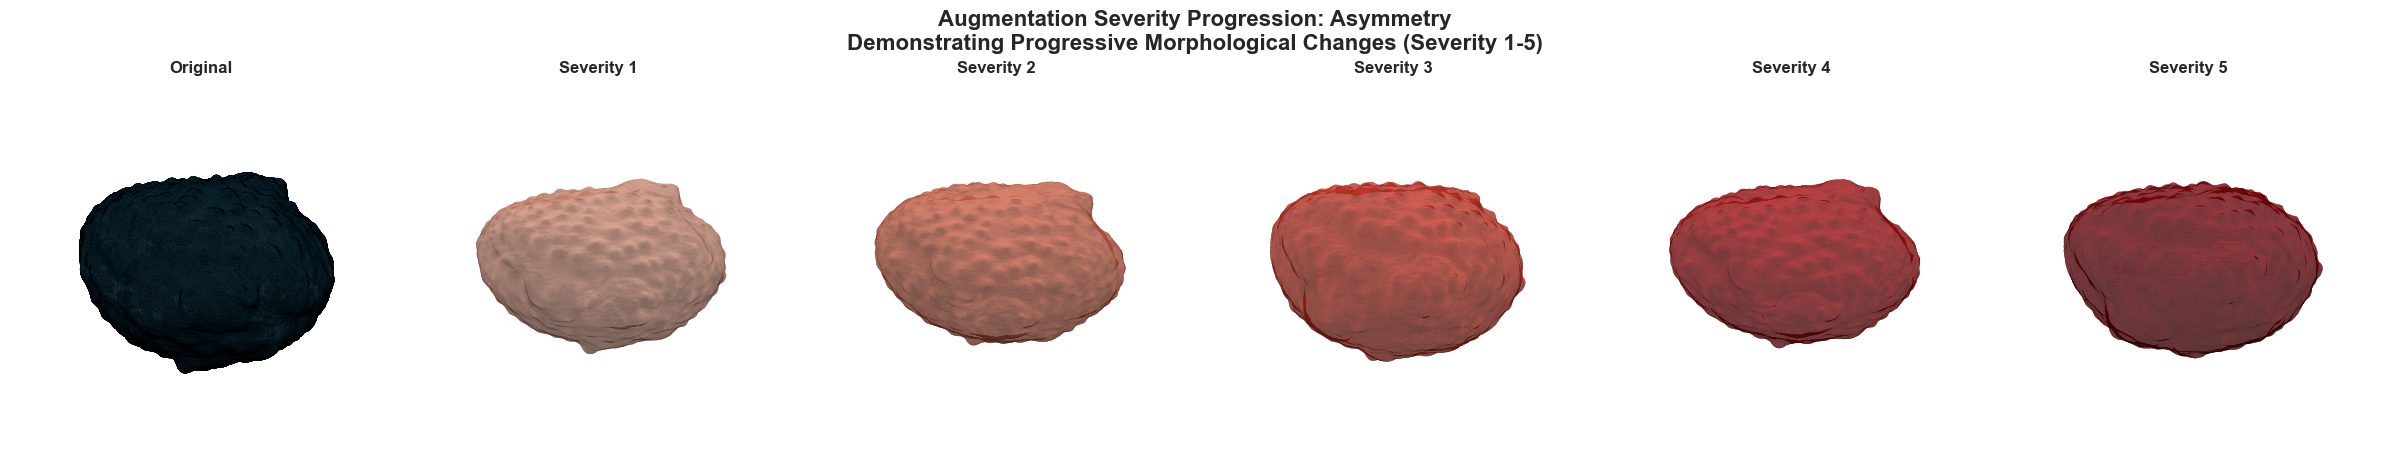

In [ ]:
def create_augmentation_severity_comparison():
    """Create a comparison showing different severity levels of a single augmentation strategy"""

    # Choose one strategy to demonstrate severity levels
    demo_strategy = "asymmetry"  # You can change this to any strategy
    base_path = Path("../data/processed/augmentation")
    sample_base_name = "17767_Common_knapweed_Centaurea_nigra_pollen_grain"

    # Load different severity levels (1-5)
    severity_meshes = {}
    strategy_path = base_path / demo_strategy

    if strategy_path.exists():
        for severity in range(1, 6):
            pattern = f"{sample_base_name}_{demo_strategy}_{severity}.stl"
            files = list(strategy_path.glob(pattern))

            if files:
                try:
                    # Load and normalize severity mesh to ensure same scale
                    raw_mesh = trimesh.load(str(files[0]))
                    severity_meshes[f"Severity {severity}"] = (
                        normalize_mesh_to_unit_box(raw_mesh)
                    )
                    print(
                        f"✓ Loaded and normalized {demo_strategy} severity {severity}"
                    )
                except Exception as e:
                    print(f"✗ Could not load {demo_strategy} severity {severity}: {e}")

    # Add original for comparison with normalization
    original_path = Path("../data/processed/interim")
    original_file = original_path / f"{sample_base_name}.stl"
    if original_file.exists():
        try:
            original_mesh_raw = trimesh.load(str(original_file))
            # Normalize the original mesh to match augmented mesh scaling
            severity_meshes["Original"] = normalize_mesh_to_unit_box(original_mesh_raw)
            print(f"✓ Loaded and normalized original mesh")
        except Exception as e:
            print(f"✗ Could not load original mesh: {e}")

    if not severity_meshes:
        print("No meshes loaded for severity comparison")
        return

    # Create visualization
    n_meshes = len(severity_meshes)
    cols = min(6, n_meshes)  # Maximum 6 columns
    rows = (n_meshes + cols - 1) // cols

    fig = plt.figure(figsize=(4 * cols, 5 * rows))
    fig.suptitle(
        f'Augmentation Severity Progression: {demo_strategy.replace("_", " ").title()}\n'
        f"Demonstrating Progressive Morphological Changes (Severity 1-5)",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )

    # Sort to put original first, then severity 1-5
    sorted_meshes = sorted(
        severity_meshes.items(),
        key=lambda x: (
            x[0] != "Original",
            int(x[0].split()[-1]) if "Severity" in x[0] else 0,
        ),
    )

    for idx, (label, mesh) in enumerate(sorted_meshes):
        ax = fig.add_subplot(rows, cols, idx + 1, projection="3d")

        # Choose color: blue for original, gradient for severities
        if label == "Original":
            color = augmentation_colors["original"]
            alpha = 0.8
        else:
            # Create color gradient from light to dark for severity levels
            severity_num = int(label.split()[-1])
            color_intensity = 0.3 + (severity_num - 1) * 0.15  # 0.3 to 0.9
            color = plt.cm.Reds(color_intensity)
            alpha = 0.7

        # Plot the mesh
        try:
            ax.plot_trisurf(
                mesh.vertices[:, 0],
                mesh.vertices[:, 1],
                mesh.vertices[:, 2],
                triangles=mesh.faces,
                color=color,
                alpha=alpha,
                linewidth=0.1,
                edgecolor="black" if label == "Original" else "none",
            )
        except Exception as e:
            print(f"Error plotting {label}: {e}")
            ax.scatter(
                mesh.vertices[:, 0],
                mesh.vertices[:, 1],
                mesh.vertices[:, 2],
                c=[color],
                alpha=alpha,
                s=1,
            )

        # Customize subplot
        ax.set_title(label, fontsize=12, fontweight="bold")
        ax.set_axis_off()

        # Set equal aspect ratio
        max_range = (
            np.array(
                [
                    mesh.vertices[:, 0].max() - mesh.vertices[:, 0].min(),
                    mesh.vertices[:, 1].max() - mesh.vertices[:, 1].min(),
                    mesh.vertices[:, 2].max() - mesh.vertices[:, 2].min(),
                ]
            ).max()
            / 2.0
        )

        mid_x = (mesh.vertices[:, 0].max() + mesh.vertices[:, 0].min()) * 0.5
        mid_y = (mesh.vertices[:, 1].max() + mesh.vertices[:, 1].min()) * 0.5
        mid_z = (mesh.vertices[:, 2].max() + mesh.vertices[:, 2].min()) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


# Create severity comparison
print("\n" + "=" * 80)
print("AUGMENTATION SEVERITY PROGRESSION ANALYSIS")
print("=" * 80)
print("Showing how augmentation effects increase with severity levels 1-5")
create_augmentation_severity_comparison()